# Reproducing previous Machine-learning paper

ddd

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

import matplotlib
import matplotlib.pyplot

In [2]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [3]:
from xbt_dataset import XbtDataset

In [23]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [4]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/annual_csv',
    'pangeo': '/data/misc/xbt-data/annual_csv/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [5]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [6]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

In [7]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


In [8]:
def classify_subset(classifier_class, xbt_subset, x_features, y_feature):
    (ml_ds, ml_encoders) = xbt_subset.filter_features(x_features).get_ml_dataset()
    (ml_target, target_encoders) = xbt_subset.filter_features([y_feature]).get_ml_dataset()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(ml_ds, ml_target)
    clf_mlp1 = classifier_class()
    clf_mlp1.fit(X_train, y_train)
    y_res_train = clf_mlp1.predict(X_train)
    metric_train = sklearn.metrics.precision_recall_fscore_support(y_train, y_res_train, average='macro')
    y_res_test = clf_mlp1.predict(X_test)
    metric_test = sklearn.metrics.precision_recall_fscore_support(y_test, y_res_test)
    return {'classifier':clf_mlp1,'metrics_train': metric_train, 'metrics_test': metric_test}

In [12]:
classify_dtree = functools.partial(classify_subset, sklearn.tree.DecisionTreeClassifier)

In [13]:
results_model1 = {}
results_manufacturer1 = {}

In [14]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
# for year in range(1967,1970):
    xbt_subset = xbt_labelled.filter_obs('year', year)
    print(f'testing classification model {year}')
    try:
        results_model1[year] = classify_dtree(xbt_subset, input_feature_names, 'model')
    except Exception as e1:
        print(f'Error processing model {year} - {e1}')
    print(f'testing classification manufacturer {year}')
    try:
        results_manufacturer1[year] = classify_dtree(xbt_subset, input_feature_names, 'manufacturer')
    except Exception as e1:
        print(f'Error processing manufacturer {year} - {e1}')


testing classification model 1966
testing classification manufacturer 1966
testing classification model 1967
testing classification manufacturer 1967


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 1968
testing classification manufacturer 1968
testing classification model 1969
testing classification manufacturer 1969
testing classification model 1970
testing classification manufacturer 1970
testing classification model 1971
testing classification manufacturer 1971
testing classification model 1972
testing classification manufacturer 1972
testing classification model 1973
testing classification manufacturer 1973
testing classification model 1974
testing classification manufacturer 1974
testing classification model 1975


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1975
testing classification model 1976
testing classification manufacturer 1976
testing classification model 1977
testing classification manufacturer 1977
testing classification model 1978
testing classification manufacturer 1978
testing classification model 1979
testing classification manufacturer 1979
testing classification model 1980
testing classification manufacturer 1980
testing classification model 1981
testing classification manufacturer 1981
testing classification model 1982
testing classification manufacturer 1982
testing classification model 1983
testing classification manufacturer 1983
testing classification model 1984
testing classification manufacturer 1984
testing classification model 1985


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1985
testing classification model 1986


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 1986
testing classification model 1987


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1987
testing classification model 1988
testing classification manufacturer 1988
testing classification model 1989


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1989
testing classification model 1990
testing classification manufacturer 1990
testing classification model 1991
testing classification manufacturer 1991
testing classification model 1992
testing classification manufacturer 1992
testing classification model 1993
testing classification manufacturer 1993
testing classification model 1994
testing classification manufacturer 1994
testing classification model 1995


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1995
testing classification model 1996


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 1996
testing classification model 1997


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1997
testing classification model 1998


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1998
testing classification model 1999


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 1999
testing classification model 2000


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2000
testing classification model 2001


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2001
testing classification model 2002


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2002
testing classification model 2003


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2003
testing classification model 2004


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification manufacturer 2004
testing classification model 2005


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification manufacturer 2005
testing classification model 2006
testing classification manufacturer 2006


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2007
testing classification manufacturer 2007


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification model 2008
testing classification manufacturer 2008
testing classification model 2009
testing classification manufacturer 2009


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification model 2010
testing classification manufacturer 2010


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

testing classification model 2011
testing classification manufacturer 2011


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2012
testing classification manufacturer 2012
testing classification model 2013
testing classification manufacturer 2013


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing classification model 2014
testing classification manufacturer 2014
testing classification model 2015
testing classification manufacturer 2015
testing classification model 2016
Error processing model 2016 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
testing classification manufacturer 2016
Error processing manufacturer 2016 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [19]:
results_model1[1980]['metrics_train']

(1.0, 0.9987856454639523, 0.999391964543024, None)

In [20]:
res_model_df = pandas.DataFrame({
'year' : list(results_model1),
'recall_model_train_per_year' : [
    results_model1[year1]['metrics_train'][1]
    for year1 in results_model1.keys()],
'precision_model_train_per_year' : [
    results_model1[year1]['metrics_train'][0]
    for year1 in results_model1.keys()],
'recall_model_test_per_year' : [
    results_model1[year1]['metrics_test'][1]
    for year1 in results_model1.keys()],
'precision_model_test_per_year' : [
    results_model1[year1]['metrics_test'][0]
    for year1 in results_model1.keys()],
})
res_model_df.sort_values(by='year', inplace=True)

In [21]:
res_manuf_df = pandas.DataFrame({
'year' : list(results_model1),
'recall_manuf_train_per_year' : [
    results_manufacturer1[year1]['metrics_train'][1]
    for year1 in results_model1.keys()],
'precision_manuf_train_per_year' : [
    results_manufacturer1[year1]['metrics_train'][0]
    for year1 in results_model1.keys()],
'recall_manuf_test_per_year' : [
    results_manufacturer1[year1]['metrics_test'][1]
    for year1 in results_model1.keys()],
'precision_manuf_test_per_year' : [
    results_model1[year1]['metrics_test'][0]
    for year1 in results_model1.keys()],
})
res_manuf_df.sort_values(by='year', inplace=True)

In [24]:
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    print(f'processing year {year}')
    xbt_subset = xbt_labelled.filter_obs('year',year)
    xbt_model1, enc_model1 = xbt_subset.filter_features(['model']).get_ml_dataset()
    enc_model1 = enc_model1[0]
    xbt_manufacturer1, enc_manuf1 = xbt_subset.filter_features(['manufacturer']).get_ml_dataset()
    enc_manuf1 = enc_manuf1[0]
    
    imeta_output = xbt_subset.xbt_df.apply(lambda x: imeta_classification(x), axis=1)
    imeta_model1 = enc_model1.transform(pandas.DataFrame({'imeta_model':imeta_output.apply(lambda x: x[0])}))
    imeta_manuf1 = enc_manuf1.transform(pandas.DataFrame({'imeta_manufacturer':imeta_output.apply(lambda x: x[1])}))
    
    if enc_model1.categories_[0].shape[0] == 1:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, imeta_model1,average='macro')
    if enc_manuf1.categories_[0].shape[0] == 1:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, imeta_manuf1,average='macro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       
                      }]

processing year 1966
processing year 1967
processing year 1968
processing year 1969
processing year 1970
processing year 1971
processing year 1972


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1973


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1974


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1975


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1976


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1977


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1978


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1979


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1980


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1981


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1982


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1983


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1984


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1985


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1986


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1987


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1988


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1989


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1990


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1991


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1992


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1993


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1994


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1995


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1996


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1997


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1998


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 1999


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2000


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2001


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2002


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2003


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2004


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2005


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2006


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2007


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2008


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2009


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2010


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2011


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2012


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2013


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2014


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


processing year 2015
processing year 2016


/root/my-conda-envs/xbt_test_20200128/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [25]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [26]:
results_df = pandas.merge(res_model_df, res_manuf_df).merge(imeta_res_df)

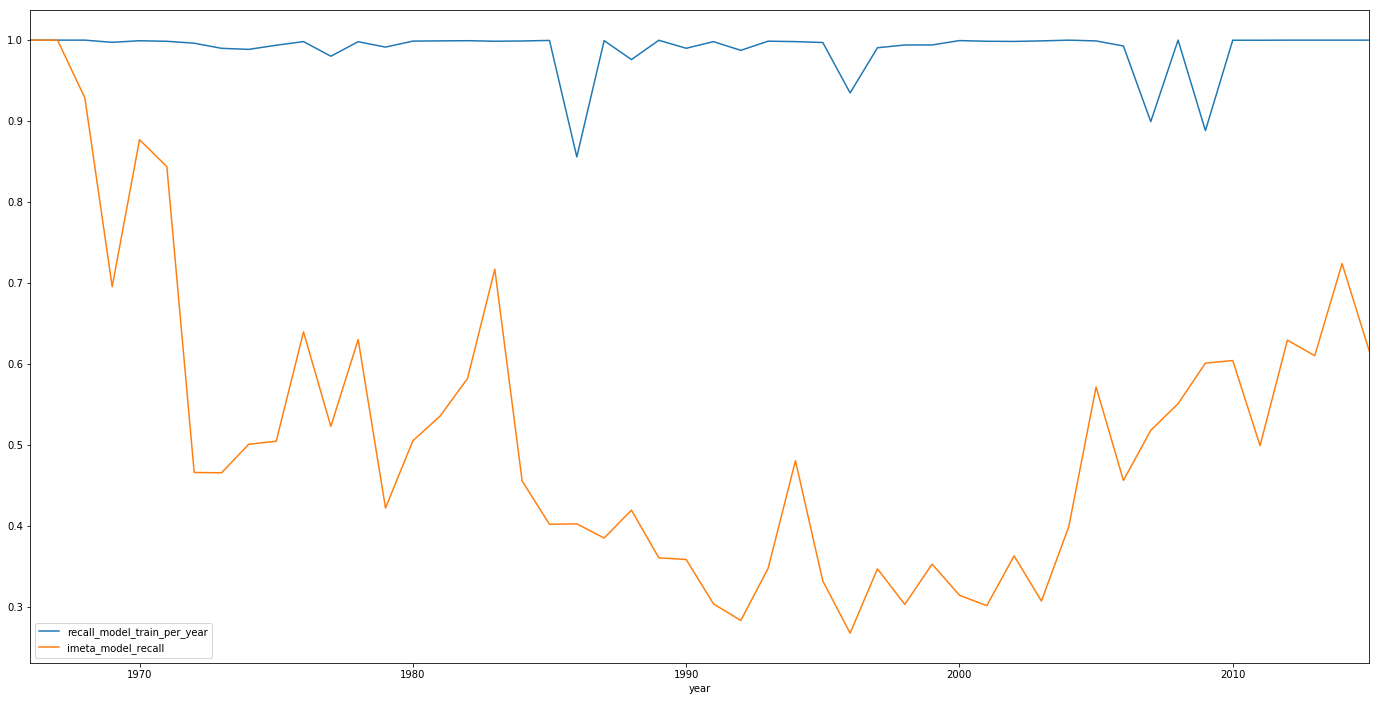

In [27]:
results_df.plot.line(x='year',y=['recall_model_train_per_year','recall_model_test_per_year', 'imeta_model_recall'], figsize=(24,12))

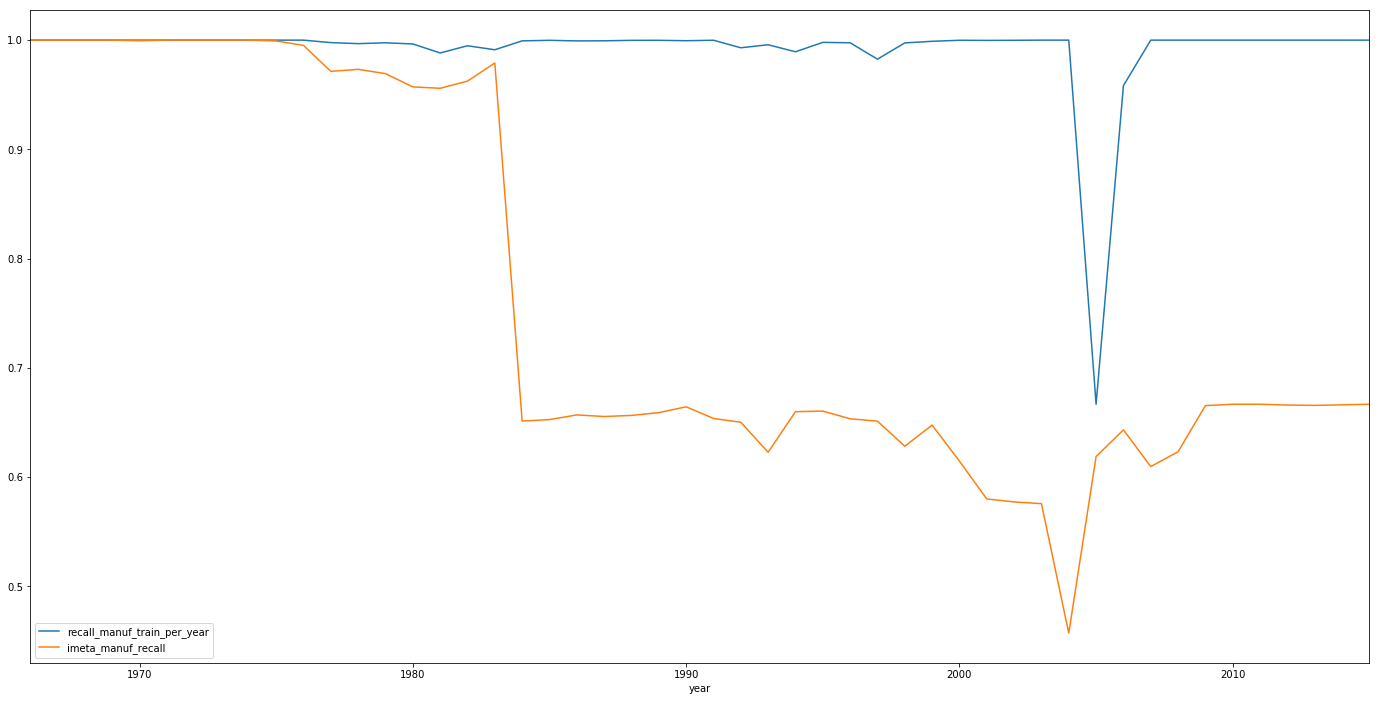

In [28]:
results_df.plot.line(x='year',y=['recall_manuf_train_per_year','recall_manuf_test_per_year', 'imeta_manuf_recall'], figsize=(24,12))